# CLASSIFICATION DES TUMEURS DU CERVEAU PAR TRAITEMENT D'IMAGES D'IRM AVEC LES RESEAUX DE NEURONNES CONVOLUTIFS (CNN)

## TABLE DE MATIERE

### 1. À propos des Données
    1.1 Introduction au jeu de données :
        1.1.1 Fournir un aperçu bref du jeu de données utilisé.
        1.1.2 Expliquer la source des données et le contexte pertinent.
        1.1.3 Décrire le but du projet.
        
### 2. Importations et Configuration
    2.1 Importer les bibliothèques nécessaires
    2.2 Configurer les paramètres
    
### 3. Importation des Données
    3.1 Charger le jeu de données 
    3.2 Afficher les cardinalités du jeu de données pour comprendre sa structure
    
### 4. Visualisation des Données
    4.1 Créer des visualisations pour comprendre la distribution des données
    4.2 Afficher quelques exemples de données et leur label associé
    
### 5. Prétraitement des Données et Configuration des Paramètres d'Entrainement
    5.1 Prétraitement des données
    5.2 configuration des paramètres d'entrainement
    
### 6. Métriques d'Évaluation du Modèle
    6.1 Précision
    6.2 Rappel
    2.3 F-1 Score
    2.4 Accurancy
    
### 7. Initialisation du Modèle
    7.1 Définir l'Architecture du Modèle
    7.1 Visualisation de l'Architecture du Modèle

### 8. Implémentation du Modèle
    8.1 Entrainement du Modèle
    8.2 Evaluation du Modèle
    
### 9. Implémentation du Modèle et Conclusion


## 1|  À propos des Données

## 2|  Importations et Configuration

In [5]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img


In [8]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

## 3| Importation des Données

In [9]:
def get_data_labels(directory):
    paths = []
    labels = []
    
    # Parcourir les sous-dossiers dans le répertoire principal
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        
        # Vérifier que c'est bien un répertoire
        if os.path.isdir(label_dir):
            # Parcourir les fichiers dans le sous-dossier
            for filename in os.listdir(label_dir):
                file_path = os.path.join(label_dir, filename)
                
                # Ajouter le chemin du fichier et le label à leurs listes respectives
                paths.append(file_path)
                labels.append(label)
    
    return paths, labels

In [10]:
from PIL import Image  # Assuming you use PIL for image loading

def get_data_labels(data_dir):

    image_paths = []
    labels = []

  # Loop through subdirectories (assuming they represent labels)
    for label_dir in os.listdir(data_dir):
        # Get the full path to the label directory
        label_path = os.path.join(data_dir, label_dir)

        # Check if it's a directory (not a file)
        if os.path.isdir(label_path):
              # Loop through images in the label directory
            for filename in os.listdir(label_path):
                # Get the full path to the image
                image_path = os.path.join(label_path, filename)

                # Append the image path and label to the respective lists
                image_paths.append(image_path)
                labels.append(label_dir)  # Label is the name of the subdirectory

    return image_paths, labels

In [11]:
# Setting up file paths for training and testing
USER_PATH = r"brain-tumor-mri-dataset"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


## 4| Visualisation des Données

Training Counts
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing Counts
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


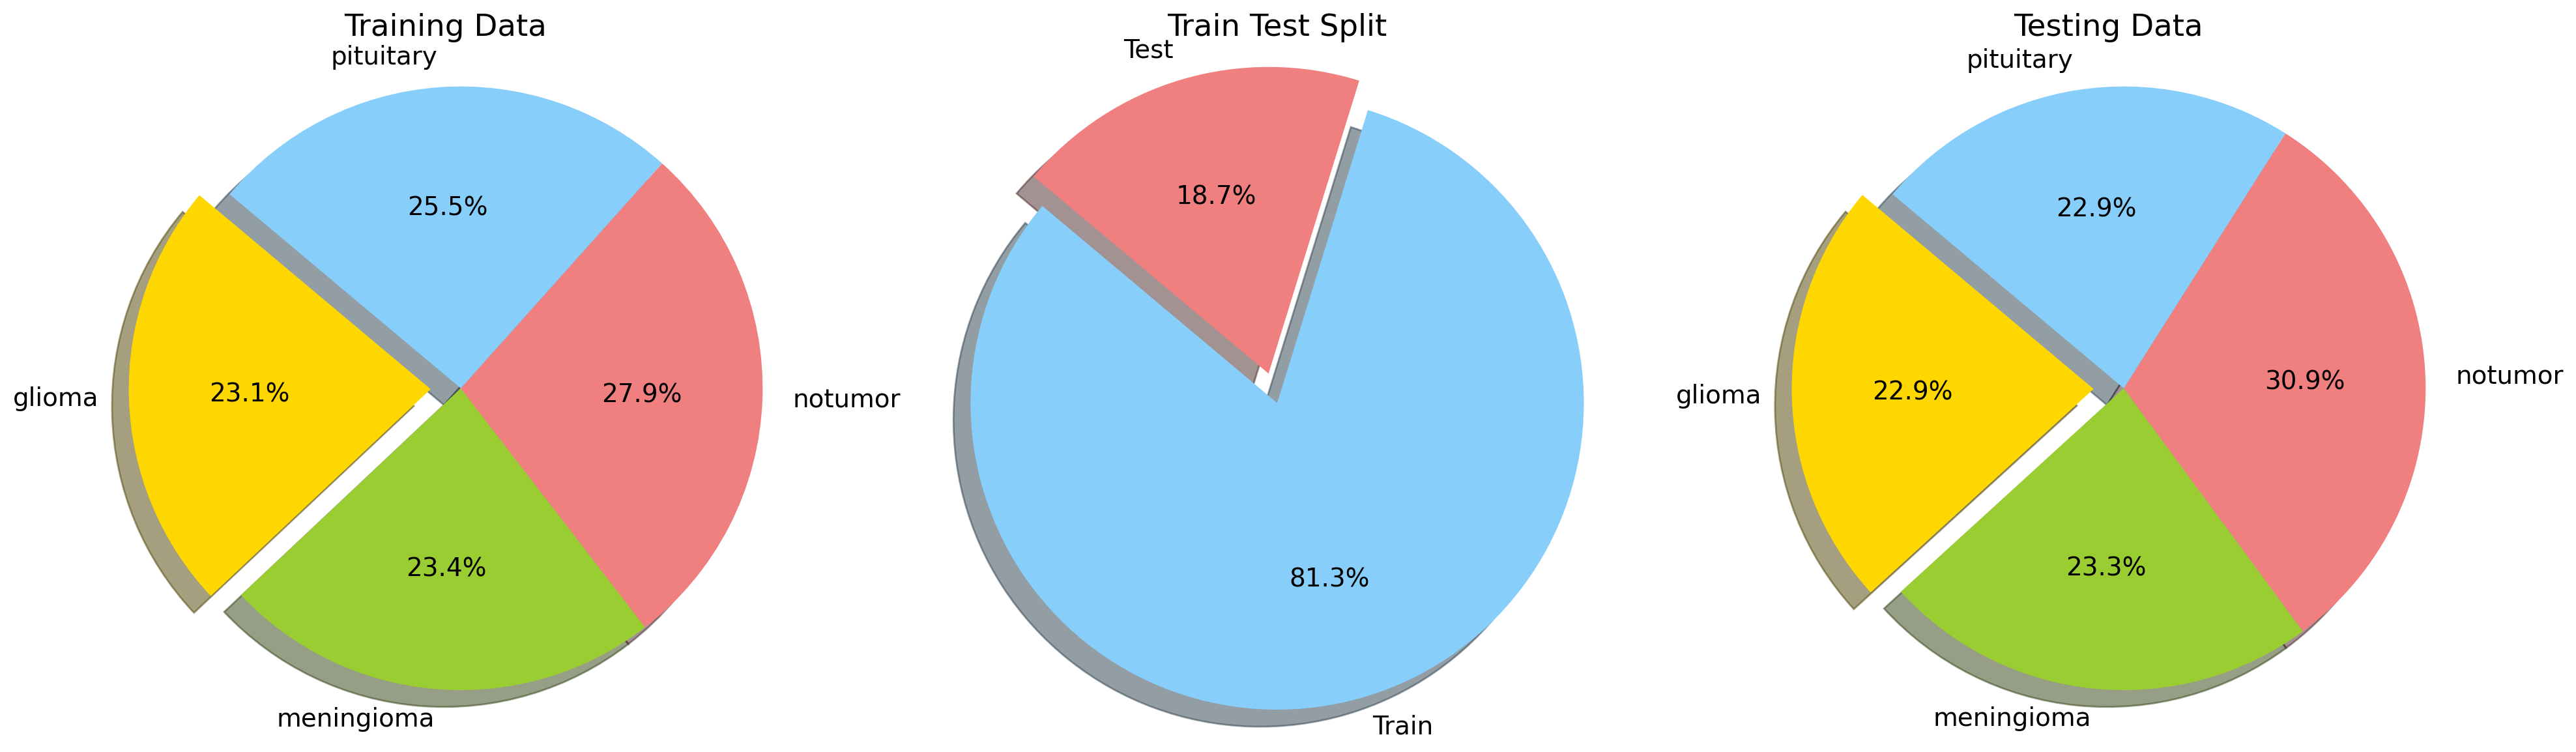

In [12]:
# Fonction pour compter les occurrences de chaque classe
def count_labels(labels):
    counts = {}
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

# Comptage des occurrences des classes
train_counts = count_labels(train_labels)
test_counts = count_labels(test_labels)

# Impression des comptages
print('Training Counts')
print(train_counts)
print('Testing Counts')
print(test_counts)

# Fonction pour créer des graphiques en secteurs
def plot_pie_chart(counts, title, ax):
    labels = counts.keys()
    sizes = counts.values()
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0, 0)  # "exploser" la première tranche

    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')  # Assure que le cercle est dessiné.
    ax.set_title(title)

# Créer une figure avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Visualisation des données d'entraînement
plot_pie_chart(train_counts, 'Training Data', axes[0])

# Visualisation des données de test
plot_pie_chart(test_counts, 'Testing Data', axes[2])

# Ajout du diagramme de répartition "Train Test Split"
train_size = len(train_paths)
test_size = len(test_paths)
sizes = [train_size, test_size]
labels = ['Train', 'Test']
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
axes[1].axis('equal')  # Assure que le cercle est dessiné.
axes[1].set_title('Train Test Split')

# Afficher la figure
plt.tight_layout()
plt.show()

x reshaped: (1, 150, 150, 3)


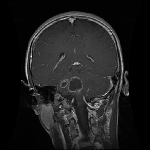

In [13]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [14]:
from PIL import Image

def show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
                index_list=[0, 94, 235, 17,
                            61, 324, 55, 45,
                            374, 65, 391, 488]):
    """
    Fonction pour afficher des images de classification de données avec leurs étiquettes et indices.

    Args:
        train_paths (list): Liste des chemins vers les images d'entraînement.
        train_labels (list): Liste des étiquettes correspondantes pour les images d'entraînement.
        im_size (int): Taille souhaitée (largeur et hauteur) pour afficher les images.
        figsize (tuple): Taille souhaitée de la figure Matplotlib.
        index_list (list): Liste des indices spécifiques pour lesquels afficher les images.

    Exemple d'utilisation:
        show_images(train_paths, train_labels, figsize=(10, 10), index_list=[0, 10, 20, 30])
    """

    fig, axes = plt.subplots(3, 4, figsize=figsize)

    for i, index in enumerate(index_list):
        image = Image.open(train_paths[index]).resize((im_size, im_size))
        image_array = np.array(image)

        ax = axes[i // 4, i % 4]
        ax.imshow(image_array)
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        label = train_labels[index]
        row = i // 4
        col = i % 4
        ax.text(0.1, 0.9, f"{label} - Index: {index}", color='white', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5),
                zorder=10)

    plt.tight_layout()
    plt.show()

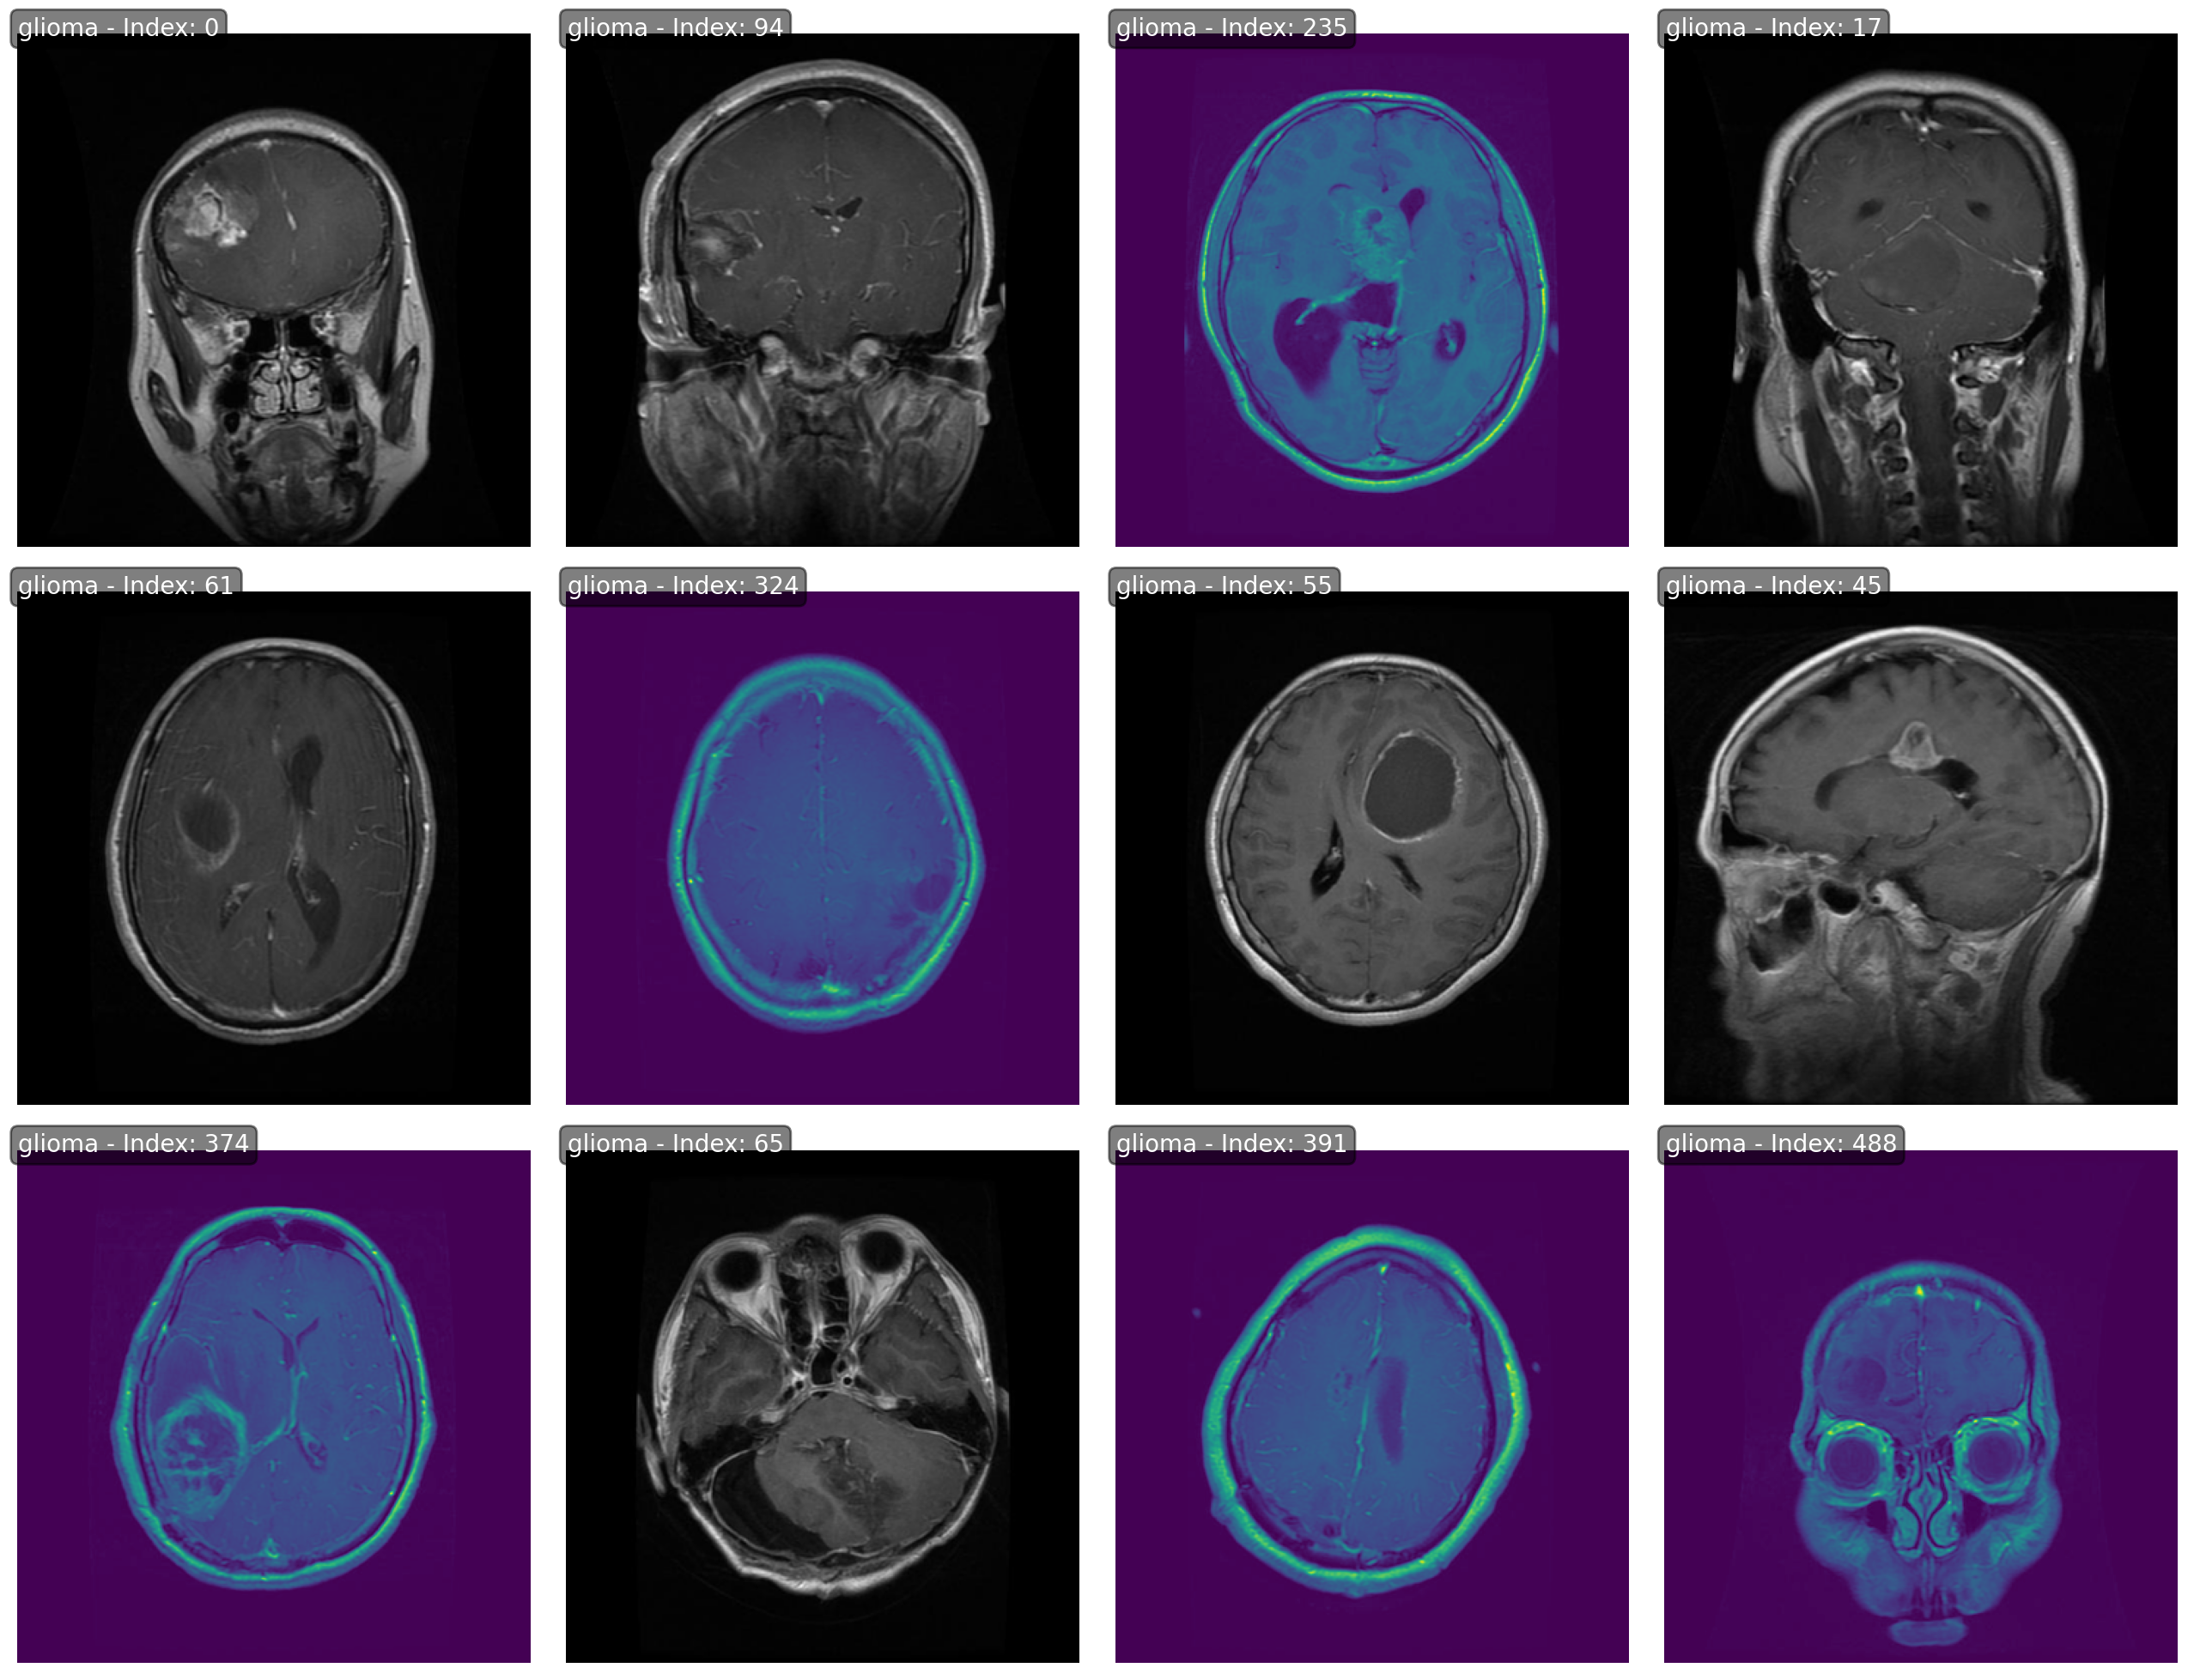

In [15]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

## 5| Prétraitement des Données et Configuration des Paramètres d'Entrainement

In [16]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:
#Data Augmentation Class Indices

# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [20]:
#Training Setup Values

# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


## 6| Métriques d'Évaluation du Modèle

## 7| Conception du Modèle Test

In [15]:
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

model_1.summary()


C:\Users\Wils\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

## 8| Conception du Modèle Final

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [17]:
from tensorflow.keras.optimizers import Adam
# Define the model architecture
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

### 8.1| Entrainement du Modèle Final

In [21]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40


C:\Users\Wils\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.4638 - loss: 1.1254 - val_accuracy: 0.7469 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 58s 333ms/step - accuracy: 0.7500 - loss: 0.5962

C:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.5962 - val_accuracy: 0.9355 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 98s 540ms/step - accuracy: 0.7881 - loss: 0.5173 - val_accuracy: 0.7547 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.8125 - loss: 0.3845 - val_accuracy: 1.0000 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 99s 543ms/step - accuracy: 0.8403 - loss: 0.4104 - val_accuracy: 0.8102 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.9688 - loss: 0.2002 - val_accuracy: 0.9032 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 97s 532ms/step - accuracy: 0.8693 - loss: 0.3380 - val_accuracy: 0.8359 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.9062 - loss: 0.298

In [1]:
# Sauvegarder le modèle entier
model.save('model.keras')

NameError: name 'model' is not defined

In [2]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

### 8.2| Evaluation du Modèle Final

In [3]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

NameError: name 'test_generator' is not defined

NameError: name 'history' is not defined

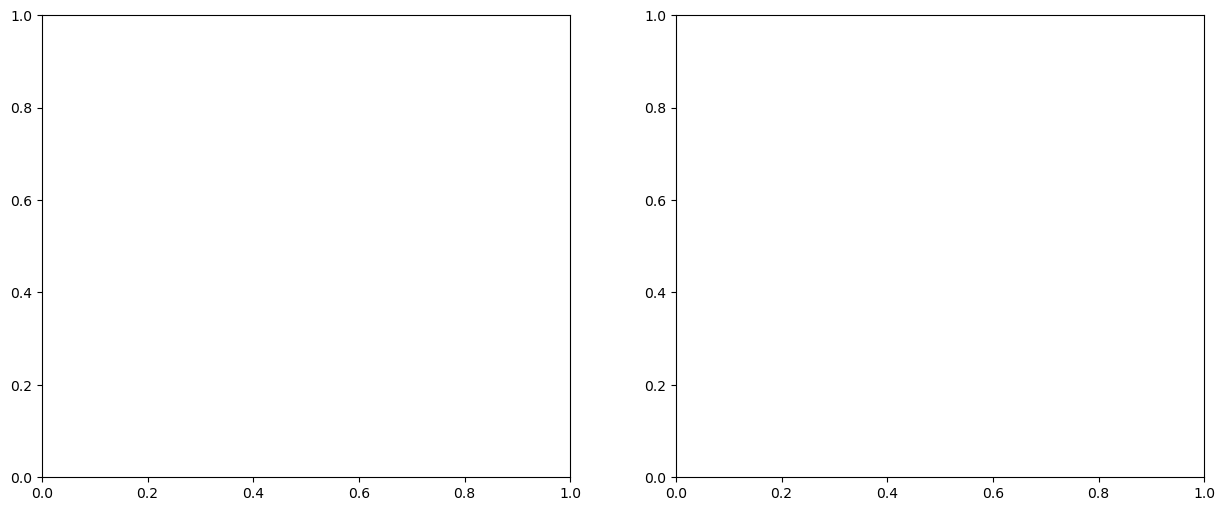

In [6]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step


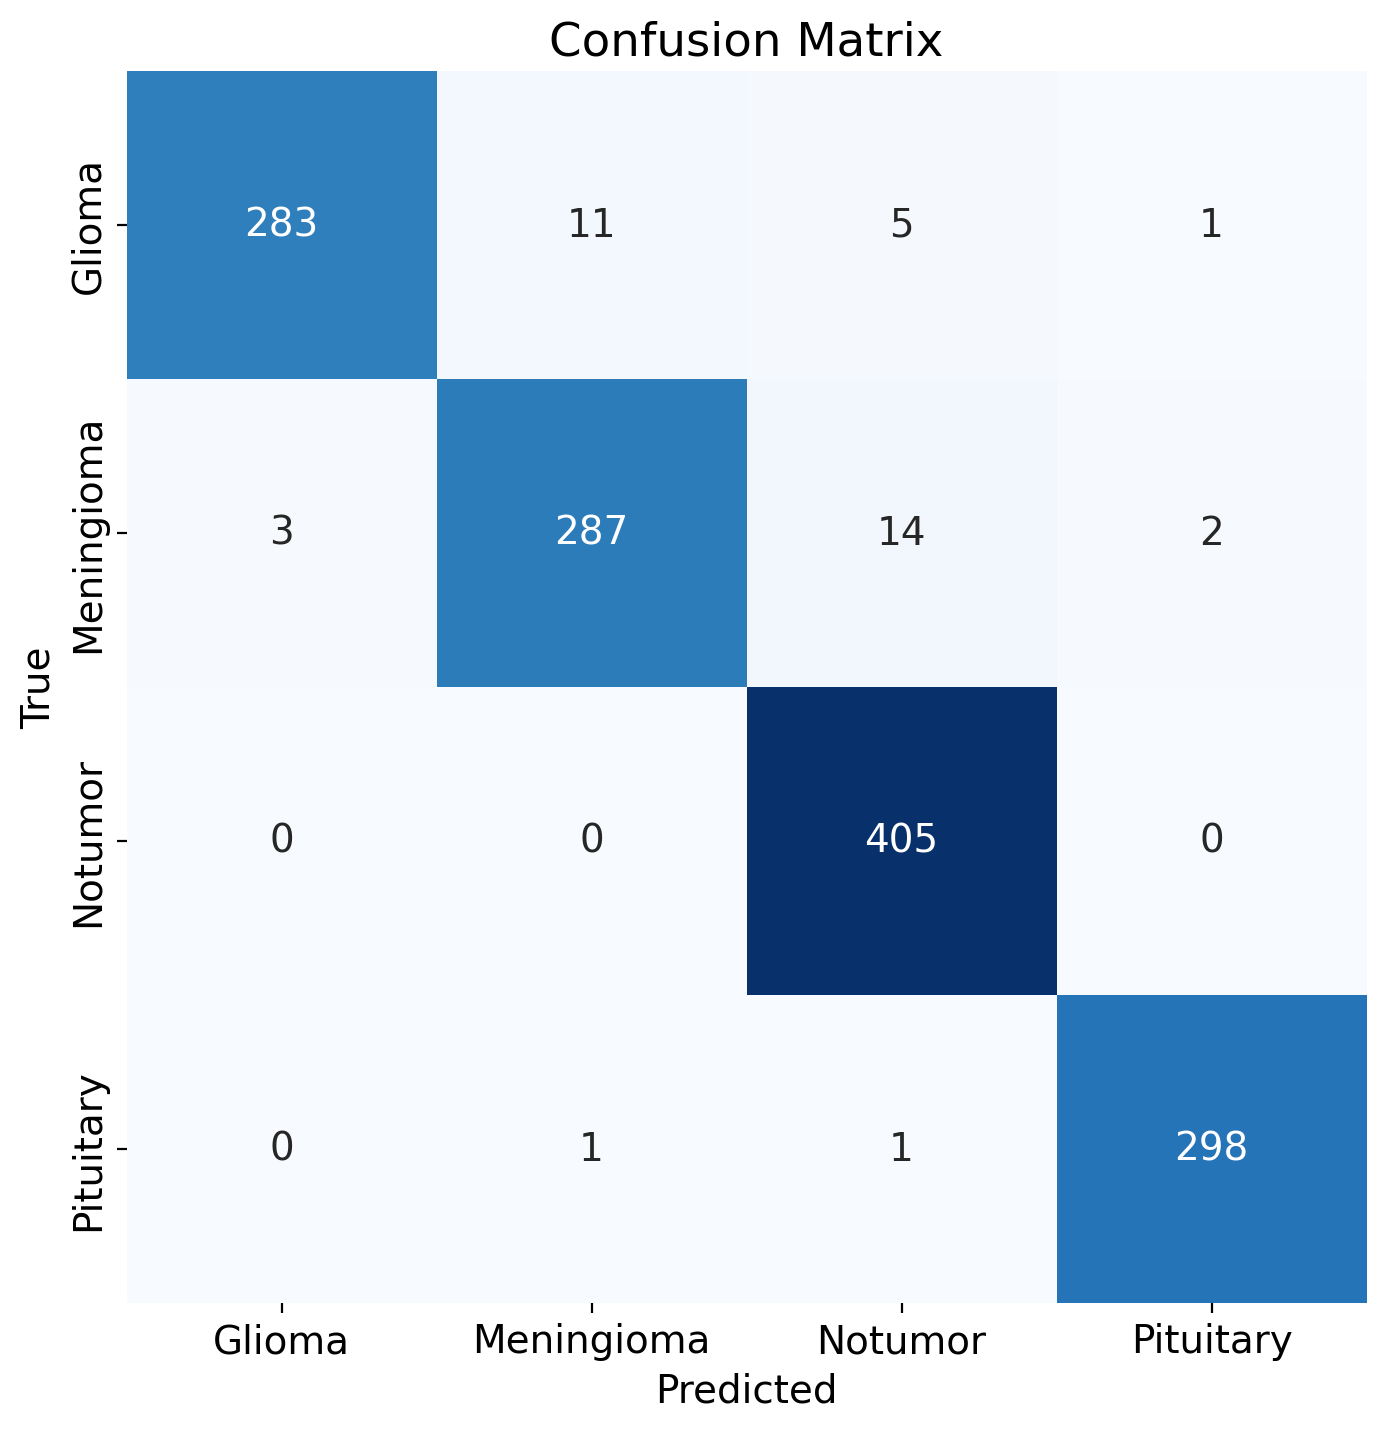

In [34]:
from sklearn.metrics import confusion_matrix
def CM(CNN_model, test_generator, categories):
    # Prédire les classes pour les images du générateur de test
    predictions = CNN_model.predict(test_generator)
    
    # Convertir les prédictions en classes
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Obtenir les étiquettes réelles du générateur de test
    true_classes = test_generator.classes
    
    # Générer la matrice de confusion
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    
    return conf_matrix

# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [45]:
def calculate_metrics(conf_matrix, categories):
    # Initialiser les dictionnaires pour les métriques
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    
    # Précision, rappel et F1-score pour chaque classe
    for i, category in enumerate(categories):
        true_positives = conf_matrix[i, i]
        false_positives = conf_matrix[:, i].sum() - true_positives
        false_negatives = conf_matrix[i, :].sum() - true_positives
        
        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        precision_dict[category] = precision
        recall_dict[category] = recall
        f1_dict[category] = f1
    
    # Calcul de l'accuracy générale
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    
    return precision_dict, recall_dict, f1_dict, accuracy


In [46]:
precision, recall, f1, accuracy = calculate_metrics(confusion_matrix, categories=class_indices_train_list)

print("Précision par classe:", precision)
print("Rappel par classe:", recall)
print("F1-score par classe:", f1)
print("Exactitude générale:", accuracy)

Précision par classe: {'glioma': 0.9895104895104895, 'meningioma': 0.959866220735786, 'notumor': 0.9529411764705882, 'pituitary': 0.9900332225913622}
Rappel par classe: {'glioma': 0.9433333333333334, 'meningioma': 0.9379084967320261, 'notumor': 1.0, 'pituitary': 0.9933333333333333}
F1-score par classe: {'glioma': 0.9658703071672354, 'meningioma': 0.9487603305785124, 'notumor': 0.9759036144578312, 'pituitary': 0.9916805324459235}
Exactitude générale: 0.9710144927536232


In [52]:
for i in class_indices_train_list:
    print("class: ",i)
    print(f"Précision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f} ")
    print(f"F1-score: {f1[i]:.4f} \n\n")


print(f"\nExactitude générale : {accuracy:.4f}")

class:  glioma
Précision: 0.9895
Recall: 0.9433 
F1-score: 0.9659 


class:  meningioma
Précision: 0.9599
Recall: 0.9379 
F1-score: 0.9488 


class:  notumor
Précision: 0.9529
Recall: 1.0000 
F1-score: 0.9759 


class:  pituitary
Précision: 0.9900
Recall: 0.9933 
F1-score: 0.9917 



Exactitude générale : 0.9710


In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

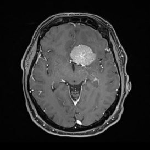

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classe prédite : meningioma


In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger le modèle CNN entraîné
model = tf.keras.models.load_model('model.h5')

# Charger et prétraiter l'image
image = load_img('Capture.jpg', target_size=(150, 150))  # Ajuster la taille de l'image selon les besoins
image_array = img_to_array(image)
image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))  # Ajouter une dimension pour la prédiction par lot
image_array = image_array.astype('float32') / 255.0  # Normaliser les valeurs des pixels
im = array_to_img(image_array[0])
display(im)

# Effectuer la prédiction
prediction = model.predict(image_array)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Interpréter la prédiction
classe_predite = np.argmax(prediction[0])
print('Classe prédite :', classes[classe_predite])

In [38]:
prediction

array([[2.114635e-06, 9.793482e-01, 2.064764e-02, 2.048881e-06]],
      dtype=float32)

In [41]:
np.round(prediction, 4)[0][0]

0.0